In [39]:
import os
from contextlib import contextmanager, nullcontext

from ax.utils.testing.mock import fast_botorch_optimize_context_manager
import plotly.io as pio

# Ax uses Plotly to produce interactive plots. These are great for viewing and analysis,
# though they also lead to large file sizes, which is not ideal for files living in GH.
# Changing the default to `png` strips the interactive components to get around this.
pio.renderers.default = "png"

SMOKE_TEST = os.environ.get("SMOKE_TEST")
NUM_EVALS = 10 if SMOKE_TEST else 30

In [40]:
# Implement custom model
from typing import Optional

from botorch.models.gpytorch import GPyTorchModel
from gpytorch.distributions import MultivariateNormal
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.means import ConstantMean
from gpytorch.models import ExactGP
from torch import Tensor


class SimpleCustomGP(ExactGP, GPyTorchModel):

    _num_outputs = 1  # to inform GPyTorchModel API

    def __init__(self, train_X, train_Y, train_Yvar: Optional[Tensor] = None):
        # NOTE: This ignores train_Yvar and uses inferred noise instead.
        # squeeze output dim before passing train_Y to ExactGP
        super().__init__(train_X, train_Y.squeeze(-1), GaussianLikelihood())
        self.mean_module = ConstantMean()
        self.covar_module = ScaleKernel(
            base_kernel=RBFKernel(ard_num_dims=train_X.shape[-1]),
        )
        self.to(train_X)  # make sure we're on the right device/dtype

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [41]:
# Create BoTorchModel from custom model
from ax.models.torch.botorch_modular.model import BoTorchModel
from ax.models.torch.botorch_modular.surrogate import Surrogate


ax_model = BoTorchModel(
    surrogate=Surrogate(
        # The model class to use
        botorch_model_class=SimpleCustomGP,
        # Optional, MLL class with which to optimize model parameters
        # mll_class=ExactMarginalLogLikelihood,
        # Optional, dictionary of keyword arguments to model constructor
        # model_options={}
    ),
    # Optional, acquisition function class to use - see custom acquisition tutorial
    # botorch_acqf_class=qExpectedImprovement,
)

In [42]:
# This is our generation strategy
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models


gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=5,  # How many trials should be produced from this generation step
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            model_kwargs={
                "surrogate": Surrogate(SimpleCustomGP),
            },
        ),
    ]
)

In [43]:
import torch
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from botorch.test_functions import Rosenbrock


# Initialize the client - AxClient offers a convenient API to control the experiment
ax_client = AxClient(generation_strategy=gs)
# Setup the experiment
ax_client.create_experiment(
    name="branin_test_experiment",
    parameters=[
        {
            "name": "x1",
            "type": "range",
            # It is crucial to use floats for the bounds, i.e., 0.0 rather than 0.
            # Otherwise, the parameter would be inferred as an integer range.
            "bounds": [0.5, 1.5],
        },
        {
            "name": "x2",
            "type": "range",
            "bounds": [0.5, 1.5],
        },
    ],
    objectives={
        "rosenbrock": ObjectiveProperties(minimize=True),
    },
)
# Setup a function to evaluate the trials
rosenbrock = Rosenbrock()


def evaluate(parameters):
    x = torch.tensor([[parameters.get(f"x{i+1}") for i in range(2)]])
    # The GaussianLikelihood used by our model infers an observation noise level,
    # so we pass an sem value of NaN to indicate that observation noise is unknown
    return {"rosenbrock": (rosenbrock(x).item(), float("nan"))}

[INFO 02-22 22:15:33] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 02-22 22:15:33] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-22 22:15:33] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 02-22 22:15:33] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x1', parameter_type=FLOAT, range=[0.5, 1.5]), RangeParameter(name='x2', parameter_type=FLOAT, range=[0.5, 1.5])], parameter_constraints=[]).


In [44]:
if SMOKE_TEST:
    fast_smoke_test = fast_botorch_optimize_context_manager
else:
    fast_smoke_test = nullcontext

# Set a seed for reproducible tutorial output
torch.manual_seed(0)

In [45]:
with fast_smoke_test():
    for i in range(NUM_EVALS):
        parameters, trial_index = ax_client.get_next_trial()
        # Local evaluation here can be replaced with deployment to external system.
        ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 02-22 22:15:33] ax.service.ax_client: Generated new trial 0 with parameters {'x1': 0.875055, 'x2': 1.457304}.


[INFO 02-22 22:15:33] ax.service.ax_client: Completed trial 0 with data: {'rosenbrock': (47.844238, nan)}.
[INFO 02-22 22:15:33] ax.service.ax_client: Generated new trial 1 with parameters {'x1': 0.930564, 'x2': 1.468646}.
[INFO 02-22 22:15:33] ax.service.ax_client: Completed trial 1 with data: {'rosenbrock': (36.329304, nan)}.
[INFO 02-22 22:15:33] ax.service.ax_client: Generated new trial 2 with parameters {'x1': 1.442705, 'x2': 0.821083}.
[INFO 02-22 22:15:33] ax.service.ax_client: Completed trial 2 with data: {'rosenbrock': (159.03511, nan)}.
[INFO 02-22 22:15:33] ax.service.ax_client: Generated new trial 3 with parameters {'x1': 1.381031, 'x2': 1.102507}.
[INFO 02-22 22:15:33] ax.service.ax_client: Completed trial 3 with data: {'rosenbrock': (64.905708, nan)}.
[INFO 02-22 22:15:33] ax.service.ax_client: Generated new trial 4 with parameters {'x1': 1.495621, 'x2': 1.494216}.
[INFO 02-22 22:15:33] ax.service.ax_client: Completed trial 4 with data: {'rosenbrock': (55.401005, nan)}.
[

In [46]:
ax_client.get_trials_data_frame()


[WARNING 02-22 22:16:27] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


,trial_index,arm_name,trial_status,generation_method,rosenbrock,x1,x2
0,0,0_0,COMPLETED,Sobol,47.844238,0.875055,1.457304
1,1,1_0,COMPLETED,Sobol,36.329304,0.930564,1.468646
2,2,2_0,COMPLETED,Sobol,159.035110,1.442705,0.821083
3,3,3_0,COMPLETED,Sobol,64.905708,1.381031,1.102507
4,4,4_0,COMPLETED,Sobol,55.401005,1.495621,1.494216
5,5,5_0,COMPLETED,BoTorch,42.997086,0.806517,1.305905
6,6,6_0,COMPLETED,BoTorch,33.247395,1.388245,1.351928
7,7,7_0,COMPLETED,BoTorch,105.805229,0.549183,1.329231
8,8,8_0,COMPLETED,BoTorch,0.400852,1.117433,1.310872
9,9,9_0,COMPLETED,BoTorch,6.500000,0.500000,0.500000


[INFO 02-22 22:16:27] ax.service.ax_client: Retrieving contour plot with parameter 'x1' on X-axis and 'x2' on Y-axis, for metric 'rosenbrock'. Remaining parameters are affixed to the middle of their range.


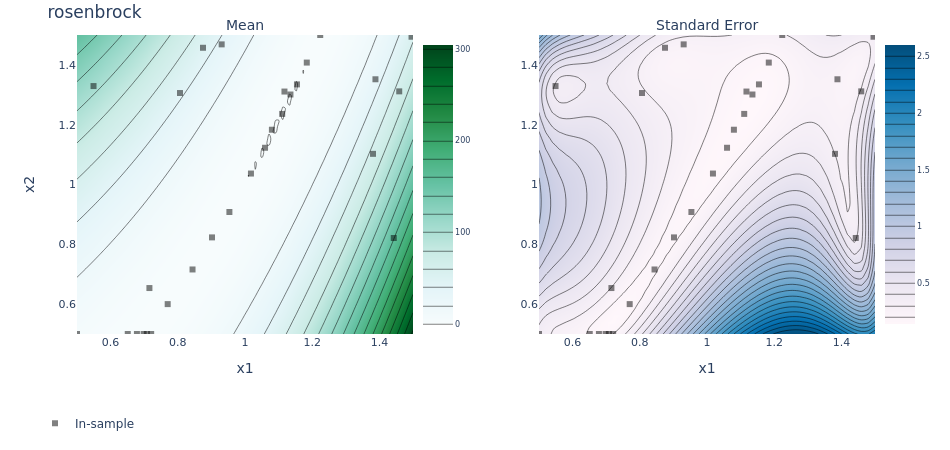

In [47]:
from ax.utils.notebook.plotting import render

render(ax_client.get_contour_plot())

In [48]:
best_parameters, values = ax_client.get_best_parameters()
best_parameters, values[0]

({'x1': 1.1107319449727802, 'x2': 1.2361056138469233},
 {'rosenbrock': -0.04306310206851549})

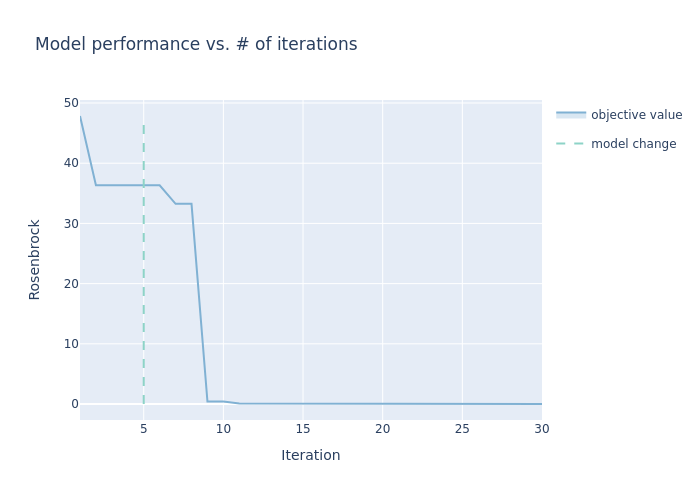

In [50]:
render(ax_client.get_optimization_trace())